[Resource](https://numpy.org/numpy-tutorials/content/tutorial-svd.html)

# Content

In this tutorial, we will use a matrix decomposition from linear algebra, the Singular Value Decomposition, to generate a compressed approximation of an image. We'll use the `face` image from the scipy.datasets module:

In [1]:
# TODO: Rm try-except with scipy 1.10 is the minimum supported version
try:
    from scipy.datasets import face
except ImportError:  # Data was in scipy.misc prior to scipy v1.10
    from scipy.misc import face

img = face()

Now, `img` is a NumPy array, as we can see when using the `type` function:

In [ ]:
type(img)

(768, 1024, 3)


We can see the image using the `matplotlib.pyplot.imshow` function and the special iPython command, `%matplotlib inline` to display plots inline:

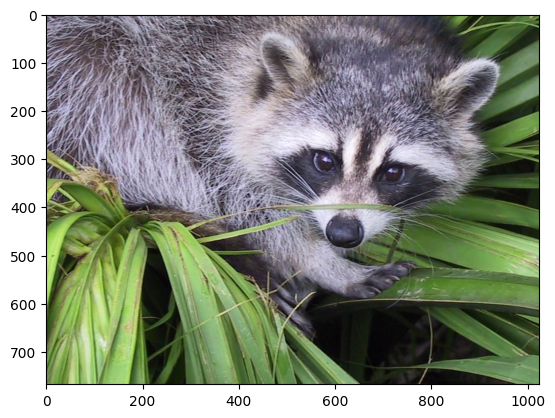

In [9]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.imshow(img)
plt.show()

# Shape, Axis, and Array Properties

Note that, in linear algebra, the dimension of a vector refers to the number of entries in an array. In NumPy, it instead defines the number of axes. For example, a 1D array is a vector such as `[1, 2, 3]`, a 2D array is a matrix, and so forth.

First, let's check for the shape of the data in our array. Since this image is two-dimensional (the pixels in te image form a rectangle), we might expect a two-dimensional array to represent it (a matrix). However, using the `shape` property of this NumPy array gives us a different result:

In [11]:
img.shape

(768, 1024, 3)

The output is a tuple with three elements, which means that this is a three-dimensional array. In fact, since this is a color image, and we have used the `imread` function to read it, the data is organized in three 2D arrays, representing color channels (in this case, red, green, and blue). You can see this by looking at the shape above: it indicates that we have an array of 3 matrices, each having shape 768x1024.

Furthermore, using the `ndim` property of this array, we can see that

In [12]:
img.ndim

3

NumPy refers to each dimension as an *axis*. Because of how `imread` works, the *first index* in the *3rd axis* is the red pixel data for our image. We can access this by using the syntax

In [ ]:
img[:, :, 0]

array([[121, 138, 153, ..., 119, 131, 139],
       [ 89, 110, 130, ..., 118, 134, 146],
       [ 73,  94, 115, ..., 117, 133, 144],
       ...,
       [ 87,  94, 107, ..., 120, 119, 119],
       [ 85,  95, 112, ..., 121, 120, 120],
       [ 85,  97, 111, ..., 120, 119, 118]],
      shape=(768, 1024), dtype=uint8)

Or, as you learned previously, you can simplify it this way:

In [14]:
img[..., 0]

array([[121, 138, 153, ..., 119, 131, 139],
       [ 89, 110, 130, ..., 118, 134, 146],
       [ 73,  94, 115, ..., 117, 133, 144],
       ...,
       [ 87,  94, 107, ..., 120, 119, 119],
       [ 85,  95, 112, ..., 121, 120, 120],
       [ 85,  97, 111, ..., 120, 119, 118]],
      shape=(768, 1024), dtype=uint8)

From the output above, we can see that every value in `img[:, :, 0]` is an integer value between 0 and 255, representing the level of red in each corresponding image pixel (keep in mind that this might be different if you use you own image instead of `scipy.datasets.face`).

As expected, this is a 768x1024 matrix:

In [16]:
img[..., 0].shape

(768, 1024)

Since we are going to perform linear algebra operations on this data, it might be more interesting to have real numbers between 0 and 1 in each entry of the matrices to represent the RGB values. We can do that by setting

In [18]:
img_array = img/255

This operation, dividing an array by a scalar, works because of NumPy's broadcasting rules. (Note that in real-world applications, it would be better to use, for example, the `img_as_float` utility function from `scikit-image`).

You can check that the above works by doing some tests; for example, inquiring about maximum and minimum values for this array:

In [19]:
img_array.max(), img_array.min()

(np.float64(1.0), np.float64(0.0))

Or checking the type of data in the array:

In [20]:
img_array.dtype

dtype('float64')

Note that we can assign each color channel to a separate matrix using the slice syntax:

In [21]:
red_array = img_array[..., 0]
green_array = img_array[..., 1]
blue_array = img_array[..., 2]

# Operations on an Axis

It's possible to use methods from linear algebra to approximate an existing set of data. Here, we will use the SVD (Singular Value Decomposition) to try to rebuild an image that uses less singular value information than the original one, while still retaining some of its features.

**Note:** We will use NumPy's linear algebra module, `numpy.linalg`, to perform the operations in this tutorial. Most of the linear algebra functions in this module can also be found in `scipy.linalg`, and users are encouraged to use the `scipy` module for real-world applications. However, some functions in the `scipy.linalg` module, such as the SVD function, only support 2D arrays.

To proceed, import the linear algebra submodule from NumPy:

In [ ]:
from numpy import linalg

In order to extract information from a given matrix, we can use the SVD to obtain 3 arrays which can be multiplied to obtain the original matrix. From the theory of linear algebra, given a matrix *A*, the following product can be computed:

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mi>U</mi>
  <mi mathvariant="normal">&#x3A3;</mi>
  <msup>
    <mi>V</mi>
    <mi>T</mi>
  </msup>
  <mo>=</mo>
  <mi>A</mi>
</math>

Where *U* and *V^T* are square and <mi mathvariant="normal">&#x3A3;</mi> are the same size as *A*. <mi mathvariant="normal">&#x3A3;</mi> is a diagonal matrix and contains the singular values of *A*, organized from largest to smallest. 